# Exercise 4
## 1. Cart Pole

The objective of these tasks are to implement two different algorithms and compare them to three environments:
* **Cart Pole**
* Lunar Lander
* Mountain Car
<br>

### <b>Group 3:</b> Cesar Laura, Ecker Annina, Dilly Julian
<div class="alert alert-block alert-info">
Note: Each of us worked on all tasks independently. We later discussed our findings and merged the best/most representative parts with eachother in one Notebook.
</div>

<br>
<hr style="height:10px;border-width:0;color:#CCD7E9;background-color:#CCD7E9">
<br>

In [1]:
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

import moviepy
from moviepy import VideoFileClip

from PIL import Image
import os
from IPython.display import Image as IPImage, display, Video, Image

from __future__ import annotations

import collections
from collections import defaultdict

import statistics

import tensorflow as tf
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch

from tqdm import tqdm
from tqdm import trange

from time import time

import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

import gc


In [9]:
gc.collect()
torch.mps.empty_cache()  # For M1/MPS

<br>
<hr style="height:10px;border-width:0;color:#CCD7E9;background-color:#CCD7E9">
<br>

In [3]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

In [4]:
env.reset(seed=123, options={"low": -0.1, "high": 0.1})  # default low=-0.05, high=0.05

(array([ 0.03647037, -0.0892358 , -0.05592803, -0.06312564], dtype=float32),
 {})

In [5]:
# Replay Buffer Class for saving the agent's experiences
class ReplayBuffer:
    '''
    Replay Buffer should help the agent to learn NOT right after each experience but rather randomly out of the buffer.
    This prevents the agent from learning from correlated data which can cause stabilizing problems in the RL process.
    Furthermore, deque(maxlen=capacity) acts as a FIFO-vault where old experiences will be overwritten.
    '''
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


In [6]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate=0.0005, gamma=0.99, hidden_units=128):
        self.q_network = QNetwork(state_dim, action_dim, hidden_units)
        self.target_network = QNetwork(state_dim, action_dim, hidden_units)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.buffer = ReplayBuffer(10000)
        self.loss_fn = nn.SmoothL1Loss()

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randrange(action_dim)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return q_values.argmax().item()

    def train(self, batch_size):
        if len(self.buffer) < batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_network(next_states).max(1)[0]
        target = rewards + self.gamma * next_q_values * (1 - dones)
        loss = self.loss_fn(q_values, target.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [7]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_units=128):
        '''
        Layer 1: Feature representations are going to be extracted from the states in fc1, where R^4 -> R^64.
        Layer 2: A deeper understanding of (non-linear) features are created in fc2, where R^64 -> R^64.
        Layer 3: The last layer delivers the output of each Q-value for each Action a (in this case, for left or right movement)
        -> R^64 -> R^2
        '''
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_units) # dense layer
        self.fc2 = nn.Linear(hidden_units,hidden_units) # dense layer
        self.fc3 = nn.Linear(hidden_units, action_dim) # Q-value for each action

    def forward(self, x):
        '''
        The usage of ReLU provides an efficient, simple strategy to enable non-linearity the QNetwork. This means, ReLU breaks up
        linear dependencies and enables the network to use more complex functions.
        At the same time it prevents the Vanisihing Gradient Problem.
        Lastly, we don't want to use ReLU on the last layer due to the fact that we want those values to be arbitrarily large and small.
        '''
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [69]:
def train_dqn(agent, env, num_episodes=10000, batch_size=12, epsilon_start=1.0, epsilon_end=0.01,
              epsilon_decay=500, reward_threshold=475, min_episodes_criterion=100):

    epsilon = epsilon_start
    episode_rewards = []
    episodes_reward_window = collections.deque(maxlen=min_episodes_criterion)
    running_reward = 0

    best_reward = 0
    best_model_state = None

    start_time = time()

    with trange(num_episodes, desc="Training", unit="ep") as t:
        for episode in t:
            state, _ = env.reset()
            total_reward = 0
            done = False

            while not done:
                action = agent.select_action(state, epsilon)
                next_state, reward, done, truncated, _ = env.step(action)
                agent.buffer.push(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                agent.train(batch_size)

            # Update Epsilon value
            epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * episode / epsilon_decay)

            # Update frequently Target Network
            if episode % 10 == 0:
                agent.target_network.load_state_dict(agent.q_network.state_dict())

            episode_rewards.append(total_reward)
            episodes_reward_window.append(total_reward)
            running_reward = statistics.mean(episodes_reward_window)

            if total_reward > best_reward:
                best_reward = total_reward
                best_model_state = agent.q_network.state_dict()

            t.set_postfix(episode_reward=total_reward, running_avg=running_reward, epsilon=epsilon)

            # Implementing early stopping
            if running_reward >= reward_threshold and episode >= min_episodes_criterion:
                print(f"\n Solved at episode {episode}: running reward {running_reward:.2f}!")
                break

    end_time = time()
    elapsed = end_time - start_time
    print(f"Training completed in {elapsed:.2f} seconds.")

    if best_model_state is not None:
        torch.save(best_model_state, 'best_dqn_cartpole.pth')
        
    return episode_rewards


In [70]:
agent = DQNAgent(state_dim, action_dim, learning_rate=0.01, gamma=0.99, hidden_units=128)

episode_rewards = train_dqn(agent, env,
                            num_episodes=500,
                            batch_size=128,
                            epsilon_start=1.0,
                            epsilon_end=0.01,
                            epsilon_decay=500)


Training: 100%|████████████████████████| 500/500 [01:10<00:00,  7.12ep/s, episode_reward=18, epsilon=0.375, running_avg=46.4]

Training completed in 70.25 seconds.


In [71]:
smoothed_rewards = pd.Series(episode_rewards).rolling(window=10).mean()

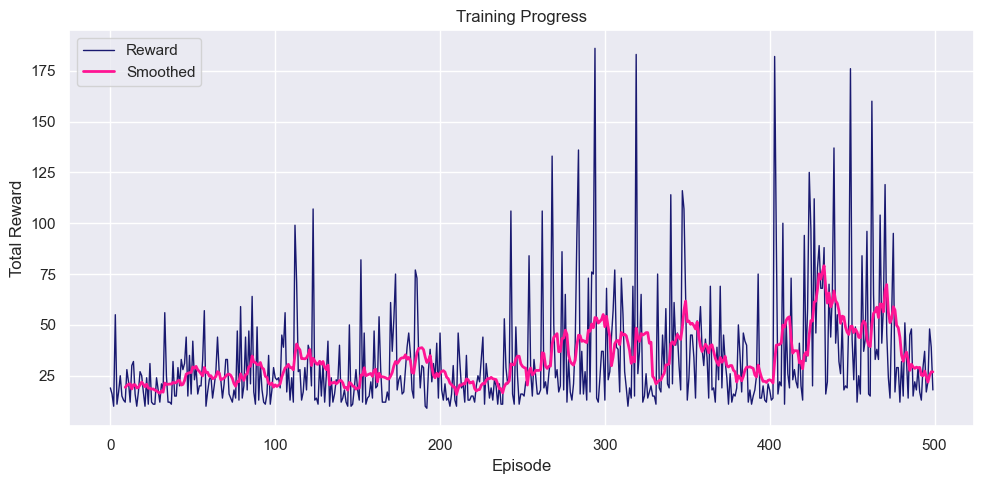

In [72]:
sns.set(style="darkgrid")

plt.figure(figsize=(10,5))
sns.lineplot(x=np.arange(len(episode_rewards)), y=episode_rewards, label='Reward',
             linewidth=1, color='MidnightBlue')
sns.lineplot(x=np.arange(len(smoothed_rewards)), y=smoothed_rewards, label='Smoothed',
             linewidth=2, color='DeepPink')

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.legend()
plt.tight_layout()
plt.show()


<br>

Reward-Verlauf zeigt: Der Agent lernt.
Der starke Ausreißer über 800 ist auffällig – vermutlich ein „lucky“ Run, aber grundsätzlich sieht man einen Aufwärtstrend.
<br>

<hr>

<br>

In [73]:
torch.save(agent.q_network.state_dict(), 'dqn_cartpole.pth')


In [74]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env = RecordVideo(env, video_folder="cartpole-agent", name_prefix="eval",
                  episode_trigger=lambda x: True)
env = RecordEpisodeStatistics(env, buffer_length=1)

agent.q_network.load_state_dict(torch.load('best_dqn_cartpole.pth'))
agent.q_network.eval()

state, _ = env.reset()
done = False
step_count = 0

while not done:
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        q_values = agent.q_network(state_tensor)
        action = q_values.argmax().item()

    state, reward, done, truncated, _ = env.step(action)
    step_count += 1

env.close()
print(f"Finished episode after {step_count} steps.")
print("Video successfully saved in folder 'cartpole-agent'!")


/Users/annina/miniconda3/envs/rdl_t4/lib/python3.9/site-packages/gymnasium/wrappers/rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
/Users/annina/miniconda3/envs/rdl_t4/lib/python3.9/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/annina/Documents/FH/FHStPoelten/RDL/assign4/cartpole-agent folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Finished episode after 233 steps.
Video successfully saved in folder 'cartpole-agent'!


In [77]:
Video("cartpole-agent/eval-episode-0.mp4", embed=True)


In [93]:
clip = VideoFileClip("cartpole-agent/eval-episode-0.mp4")
clip.write_gif("cartpole_agent_run.gif", fps=30)

{'video_found': True, 'audio_found': False, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [600, 400], 'bitrate': 35, 'fps': 50.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.19.100 libx264'}}], 'input_number': 0}], 'duration': 4.66, 'bitrate': 41, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [600, 400], 'video_bitrate': 35, 'video_fps': 50.0, 'video_duration': 4.66, 'video_n_frames': 233}
/Users/annina/miniconda3/envs/rdl_t4/lib/python3.9/site-packages/imageio_ffmpeg/binaries/ffmpeg-macos-aarch64-v7.1 -i cartpole-agent/eval-episode-0.mp4 -loglevel error -f image2pipe

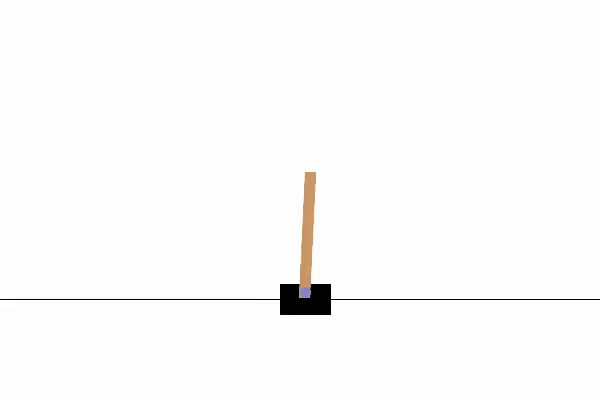

In [94]:
Image(filename="cartpole_agent_run.gif")

# Sources:

* [Tensorflow Tutorials - Reinforcement Learning](https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic)
* [Gymnasium Introduction - Training an Agent](https://gymnasium.farama.org/introduction/train_agent/)

<br>
<hr style="height:10px;border-width:0;color:#CCD7E9;background-color:#CCD7E9">
<br>

In [109]:
# --- Replay Buffer ---
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)



# --- Q-Network ---
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_units=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


        
# --- DQN Agent ---
class DQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate=0.0005, gamma=0.99, hidden_units=64):
        self.q_network = QNetwork(state_dim, action_dim, hidden_units).to(device)
        self.target_network = QNetwork(state_dim, action_dim, hidden_units).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.buffer = ReplayBuffer(10000)
        self.loss_fn = nn.SmoothL1Loss()

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randrange(action_dim)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return q_values.argmax().item()

    def train(self, batch_size):
        if len(self.buffer) < batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample(batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_network(next_states).max(1)[0]
        target = rewards + self.gamma * next_q_values * (1 - dones)
        loss = self.loss_fn(q_values, target.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


        

# --- Training---
def train_dqn(agent, env, num_episodes=2000, batch_size=16, epsilon_start=1.0, epsilon_end=0.05,
              epsilon_decay=1500, reward_threshold=200, min_episodes_criterion=100):

    epsilon = epsilon_start
    episode_rewards = []
    episodes_reward_window = collections.deque(maxlen=min_episodes_criterion)
    running_reward = 0
    best_reward = -float('inf')
    best_model_state = None

    start_time = time()

    with trange(num_episodes, desc="Training", unit="ep") as t:
        for episode in t:
            state, _ = env.reset()
            total_reward = 0
            done = False

            while not done:
                action = agent.select_action(state, epsilon)
                next_state, reward, done, truncated, _ = env.step(action)
                agent.buffer.push(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                agent.train(batch_size)

            epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * episode / epsilon_decay)

            if episode % 10 == 0:
                agent.target_network.load_state_dict(agent.q_network.state_dict())

            episode_rewards.append(total_reward)
            episodes_reward_window.append(total_reward)
            running_reward = statistics.mean(episodes_reward_window)

            if total_reward > best_reward:
                best_reward = total_reward
                best_model_state = agent.q_network.state_dict()

            t.set_postfix(episode_reward=total_reward, running_avg=running_reward, epsilon=epsilon)

            if running_reward >= reward_threshold and episode >= min_episodes_criterion:
                print(f"\nSolved at episode {episode}: running reward {running_reward:.2f}!")
                break

    end_time = time()
    elapsed = end_time - start_time
    print(f"Training completed in {elapsed:.2f} seconds.")

    if best_model_state is not None:
        torch.save(best_model_state, 'best_dqn_lunarlander.pth')

    return episode_rewards


NameError: name 'episodes' is not defined

<hr>

<br>